In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import matplotlib.pyplot as plt
import PROST
PROST.__version__

' 1.1.2 '

In [2]:
# the location of R (used for the mclust clustering)
ENVpath = "your path of PROST_ENV"            # refer to 'How to use PROST' section
os.environ['R_HOME'] = f'{ENVpath}/lib/R'
os.environ['R_USER'] = f'{ENVpath}/lib/python3.7/site-packages/rpy2'

# Set seed
SEED = 818
PROST.setup_seed(SEED)

#%% Read in data
section_num = 151672

# Set directory (If you want to use additional data, please change the file path)
rootdir = 'datasets/DLPFC'

input_dir = os.path.join(f'{rootdir}', str(section_num))
spatial_dir = os.path.join(f'{rootdir}', str(section_num),'spatial')
output_dir = os.path.join(f'{rootdir}', str(section_num), 'results')
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

In [3]:
#%% PI
adata = sc.read_visium(path=input_dir, count_file='{}_filtered_feature_bc_matrix.h5'.format(section_num))
adata.var_names_make_unique()

# Calculate PI
adata = PROST.prepare_for_PI(adata, platform="visium") 
adata = PROST.cal_PI(adata, platform="visium")

# Calculate spatial autocorrelation statistics and do hypothesis test
'''
PROST.spatial_autocorrelation(adata, k = 10, permutations = None)
'''

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.



Filtering genes ...

Calculating image index 1D:


100%|██████████| 4015/4015 [00:00<00:00, 70423.08it/s]
Trying to set attribute `.var` of view, copying.



Normalization to each gene:


100%|██████████| 5083/5083 [00:00<00:00, 13624.30it/s]



Gaussian filtering for each gene:


100%|██████████| 5083/5083 [01:07<00:00, 74.99it/s]



Binary segmentation for each gene:


100%|██████████| 5083/5083 [03:44<00:00, 22.60it/s]



Spliting subregions for each gene:


100%|██████████| 5083/5083 [01:14<00:00, 68.52it/s]



Computing PROST Index for each gene:


100%|██████████| 5083/5083 [00:03<00:00, 1478.57it/s]


PROST Index calculation completed !!


... storing 'feature_types' as categorical
... storing 'genome' as categorical



Drawing pictures:


100%|██████████| 1/1 [00:09<00:00,  9.55s/it]



Drawing completed !!


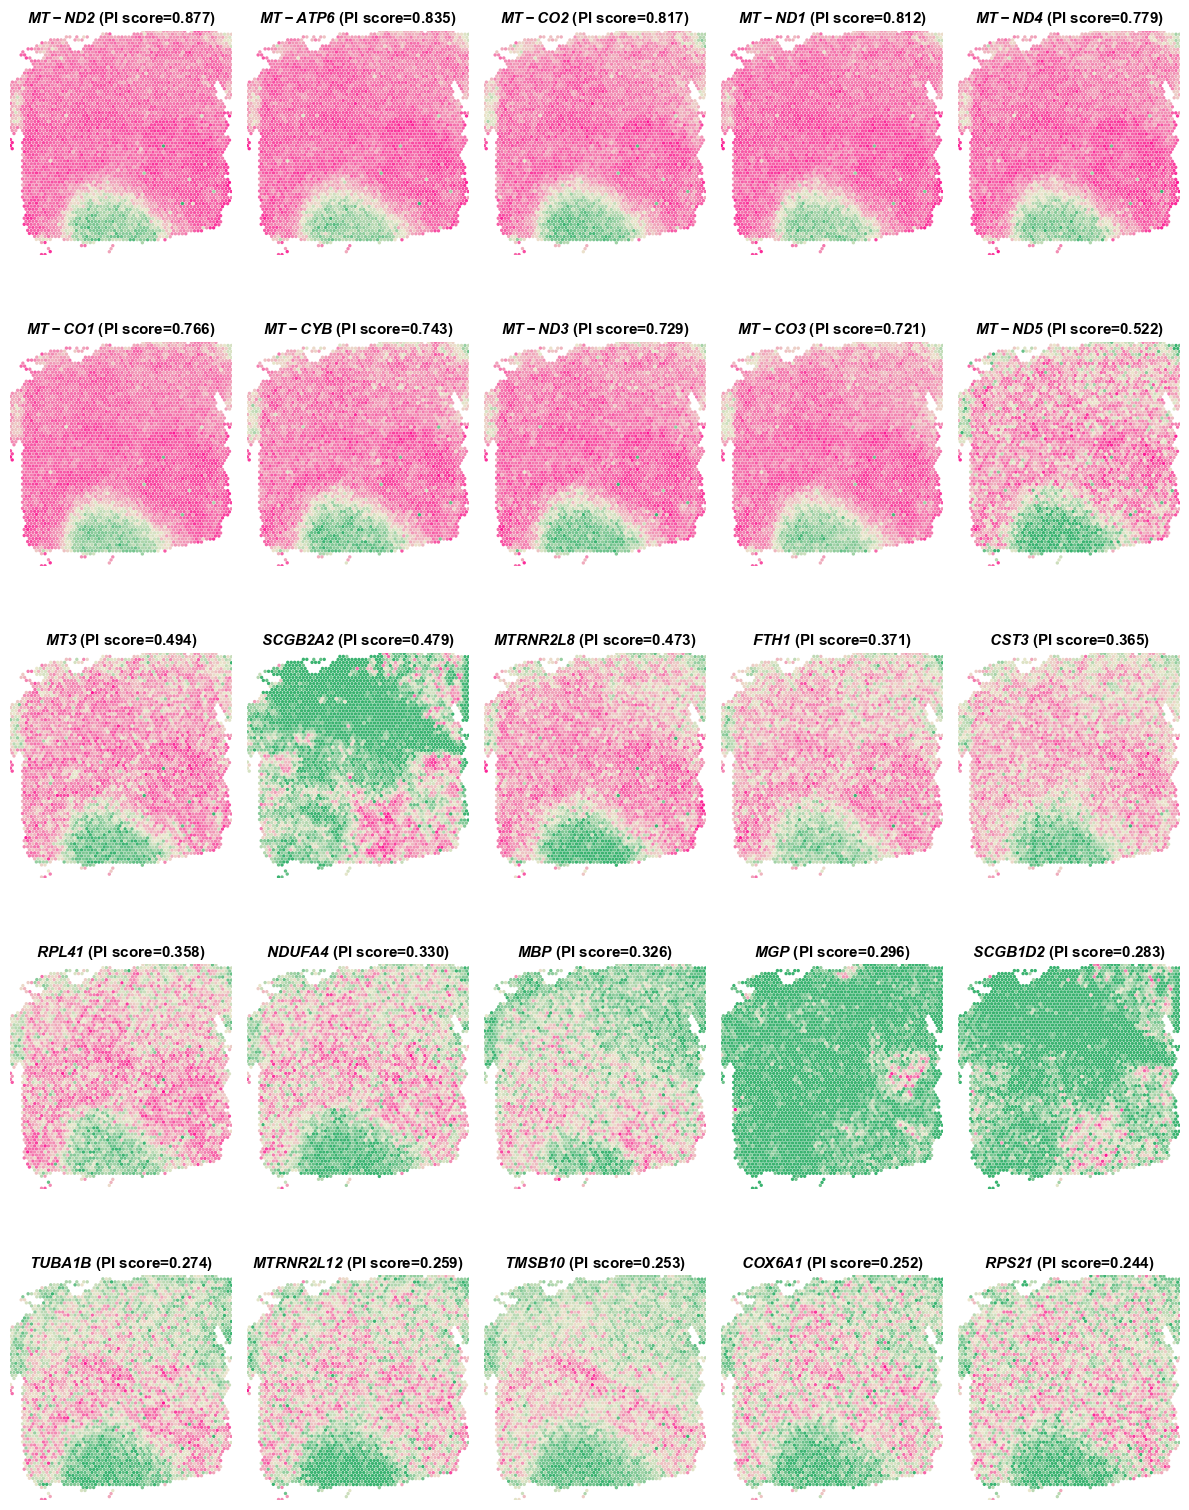

In [4]:
# Save PI result
adata.write_h5ad(output_dir+"/PI_result.h5")

# Draw SVGs detected by PI
PROST.plot_gene(adata, platform="visium",size = 2, sorted_by = "PI", top_n = 25,save_path = output_dir)

In [6]:
#%% Clustering
# Set the number of clusters
n_clusters = 5
    
# 1.Read PI result
adata = sc.read(output_dir+"/PI_result.h5")

# 2.Expression data preprocessing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata = PROST.feature_selection(adata, save_path = output_dir, by = "prost", n_top_genes = 3000)

# 3.Run PROST clustering
PROST.run_PNN(adata,
            platform="visium",
            key_added = "PROST",
            init="mclust",                         
            n_clusters = n_clusters,                        
            gnnlayers = 2,                                                                       
            laplacin_filter = True,                        
            lr = 0.1,                         
            SEED=SEED,                          
            max_epochs = 500,                        
            tol = 5e-3,                        
            post_processing = True,                        
            pp_run_times = 3)

# 4.Save result
adata.write_h5ad(output_dir+"/PNN_result.h5")   
clustering = adata.obs["clustering"]
clustering.to_csv(output_dir+"/clusters.csv",header = False)
pp_clustering = adata.obs["pp_clustering"] 
pp_clustering.to_csv(output_dir+"/pp_clusters.csv",header = False)
embedding = adata.obsm["PROST"]
np.savetxt(output_dir+"/embedding.txt",embedding)


Calculating adjacency matrix ...

Running PCA ...
Laplacian Smoothing ...

Initializing cluster centers with mclust, n_clusters known


Epoch: : 501it [09:07,  1.09s/it, loss=0.093866244]                       


Clustering completed !!

Post-processing for clustering result ...
Refining clusters, run times: 1/3
Refining clusters, run times: 2/3
Refining clusters, run times: 3/3


In [7]:
#%% Plot preparation
# Read data
adata = sc.read(output_dir+'/PNN_result.h5')

# Read annotation
labels_true = pd.read_csv(input_dir+'/cluster_labels.csv')
labels_true.index = labels_true["key"].str[7:]
adata.obs["annotation"] = labels_true["ground_truth"]
adata.obs["annotation"] = adata.obs["annotation"].astype('category').astype('str')

# Set colors
plot_color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']
cmp = mpl.colors.ListedColormap(plot_color)


... storing 'annotation' as categorical


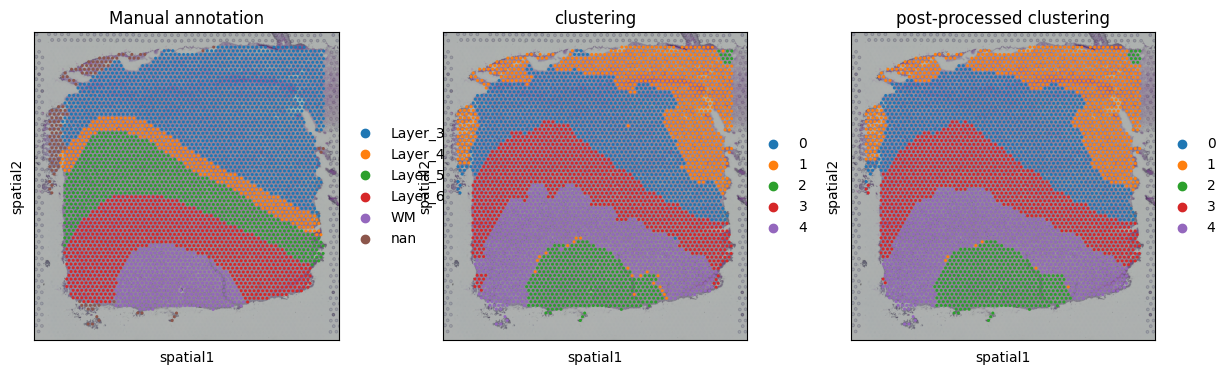

In [8]:
# Plot clustering results
plt.rcParams["figure.figsize"] = (4,4)
sc.pl.spatial(adata, 
                  img_key = "hires", 
                  color = ["annotation","clustering","pp_clustering"],
                  title = ["Manual annotation",'clustering','post-processed clustering'],                
                  na_in_legend = False,
                  ncols = 3,
                  size = 1)

In [9]:
#%% Calculate ARI and NMI
ARI, NMI, silhouette_score = PROST.cal_metrics_for_DLPFC(adata.obs["pp_clustering"], labels_true_path = input_dir+'/cluster_labels.csv')


ARI = 0.5910397042708356 
AMI = 0.6813238415316797 
NMI = 0.6818348825641031 
v_measure_score = 0.6818348825641031 
silhouette_score = 0.3681630775671734 


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'annotation' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


[<Axes:xlabel='UMAP1', ylabel='UMAP2'>, <Axes:>]

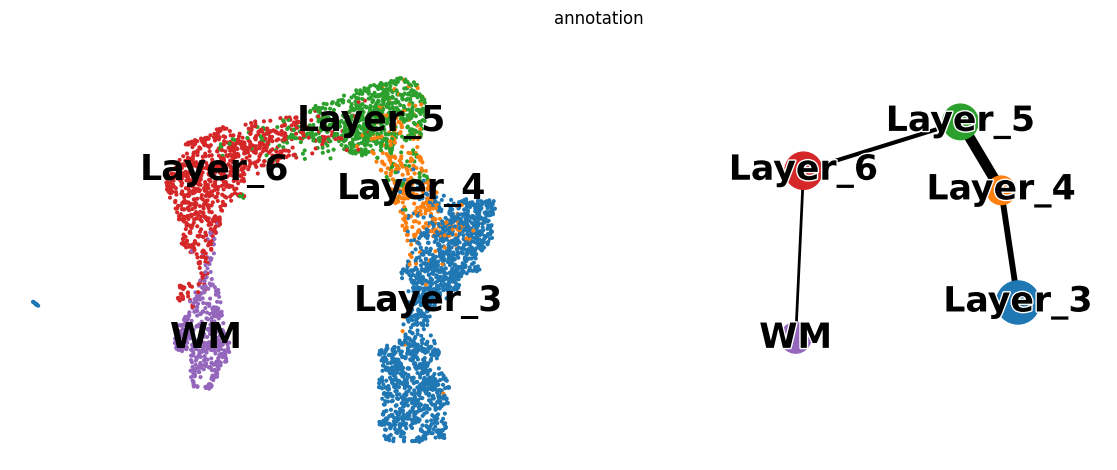

In [10]:
#%% Plot UMAP and PAGA graph
adata = sc.read_visium(path=input_dir, count_file='{}_filtered_feature_bc_matrix.h5'.format(section_num))
adata.var_names_make_unique()
# Read annotation
labels_true = pd.read_csv(input_dir+'/cluster_labels.csv')
labels_true.index = labels_true["key"].str[7:]
adata.obs["annotation"] = labels_true["ground_truth"]
adata.obs["annotation"] = adata.obs["annotation"].astype('category').astype('str')
used_adata = adata[adata.obs["annotation"]!='nan']
prost_embed = pd.read_csv(output_dir+"/embedding.txt",header = None,delim_whitespace=True)
prost_embed.index = labels_true.index
adata.obsm["PROST"] = prost_embed
# Plot
plt.rcParams["figure.figsize"] = (6,5)
sc.pp.neighbors(used_adata, use_rep="PROST")
sc.tl.umap(used_adata)
sc.tl.paga(used_adata,groups='annotation')
sc.pl.paga_compare(used_adata, color="annotation",random_state=1,
                             size = 35,legend_fontsize=25,node_size_scale=4,
                             frameon=False, show = False,fontoutline = 2)